In [195]:
import pandas as pd
import numpy as np
import time
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [4]:
%%html
<style>
table {float:left}
</style>

In [5]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
print type(digits)

<class 'sklearn.datasets.base.Bunch'>


---

(Continuing from [here](https://github.com/simpleblob/ml_algorithms_stepbystep/blob/master/algo_example_NN_multilayer_FNN.ipynb))

---

### Regularization

Source: http://www.deeplearningbook.org/contents/regularization.html

Source2: http://neuralnetworksanddeeplearning.com/chap3.html

Source3: http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf

Before moving on to more and more complex NN models, I think it's a good idea we tackle a fundamental problem of all models first -- overfitting.

Model tends to overfit, the more data we throw at it, the more features and points it can use to mimic a pattern, regardless if that pattern is really signal or noise.

#### Example of model trying too hard (blue line)
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png" style="width:400px;" align="left" />
<div style="clear:both;"></div>
---

There are many kind of promising approaches to solve this problem, the technical term for this is "regularization" -- meaning something like "making a model more regular/general and not too specific".

#### Some regularization techniques 

These are the ones we will go over today
1. **L1,L2 regularization** - adding some term to the loss function to penalize overfitting
2. **Early stopping** - stopping the model learning before it overfits too much
3. **Dropout** - removing some NN nodes to make for a simpler model

We will be using this Loss function as a base to build on.

$$ L_{base} = \dfrac{1}{2m}\sum_{j=1}^m \bigl\|\;f(w,x_j) - y_j\;\bigr\|^2 $$

---

### L2 Regularization
##### a.k.a. ridge regression, Tikhonov regularization

The most common type of regularization. we add a penalty to the loss function using square of the weights. In effect we penalty the weights with "peak" values, preferring all weight have a closer magnitude to each other.

$$ L = L_{base} + \dfrac{\lambda}{2m}\sum w^2 $$

where $\lambda$ is a scaling variable called "regularization parameter"

Due to the loss function change, our gradient update will change as well, with additional term:

$$ w(t+1) = w(t) - \eta \cdot \Delta w  - \bigl( \dfrac{\eta \cdot \lambda}{m} w(t) \bigr)$$

we can simplify into

$$ w(t+1) = \bigl( 1 -  \dfrac{\eta \cdot \lambda}{m} \bigr) w(t)  - \eta \cdot \Delta w  $$

Do note that the gradient update for bias component is still the same, affected by L2.

### L1 Regularization

Instead of squaring the weights, we use absolute value instead.

$$ L = L_{base} + \dfrac{\lambda}{2m}\sum \left|w \right| $$

$$ w(t+1) = w(t) - \dfrac{\eta \cdot \lambda}{m} \bigl| w(t) \bigr|  - \eta \cdot \Delta w  $$

In practice, L2 almost always [beat L1](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization/answer/Xavier-Amatriain?srid=uX9I) in regularization performance. So we are going to code just L2 here.

---


### Early stopping

we actually implemented this in the code already as a stopping criteria. For the below code, we will replace with this check: if no improvement in 10 epoch, stop.

### Dropout

This method concept is similar to doing ensemble models (ie. randomforest) with NN. 

Here are the steps:
1. Pick some nodes at random
2. remove them from our NN 
3. train the models with mini-batch of our data
4. update the weights with our aggregate gradients
5. repeat step 1

So effectively, we are training NN with different set of nodes/structures, and then aggregate the result.

---

### Model validation

Previously, we didn't seperate the data into training and test data. But for this topic, we need that in order to see the overfitting problem and improvement.

We will split data randomly into 80/20 train/test.

---

In [ ]:
#set size of input, features, hidden, target
instance_size = digits.images.shape[0]
feature_size = digits.images.shape[1]*digits.images.shape[2]
target_size = 10
hidden_size = 15

#make a flat 10 output with all zeros
Y = np.zeros((instance_size,10))
for j in range(0,instance_size):
    Y[j][digits.target[j]] = 1

#make a row of 64 input features instead of 8x8
X = digits.images[0:instance_size].reshape(instance_size,feature_size)
X = (X-8)/8 #normalized 

#split train and test dataset
train_split = 0.6
train_size = int(train_split*instance_size)
test_size = instance_size - train_size
index = np.random.permutation(instance_size)
train_ix, test_ix = index[:train_size], index[train_size:]
Y_train , Y_test = Y[train_ix,:], Y[test_ix,:]
X_train , X_test = X[train_ix,:], X[test_ix,:]

Xb = np.insert(X_train,0,1,axis=1) #add bias input, always activated
Xb_test = np.insert(X_test,0,1,axis=1) #add bias input, always activated

### NN v1 - Base program

First, we will run the base-version of NN (no regularization)

In [140]:
def sigmoid(w,X):
    a = 1.0/(1.0 + np.exp(-w.dot(X.transpose())))
    return a.transpose()

def loss_func(Y,y_pred,size):
    return (0.5/size)*np.sum((Y-y_pred)**2) #element-wise operation then aggregate

def initialize(target_size,feature_size,hidden_size):
    # for weights --> index = (output node , input node)
    w_hid = (np.random.rand(hidden_size,feature_size+1)-0.5) #randomized, and don't forget the bias!
    w_out = (np.random.rand(target_size,hidden_size+1)-0.5) #randomized, and don't forget the bias!

    #for f --> index = (data row , node) --- no need to initialize, just for documentation
    #f_hid = np.random.rand(train_size,hidden_size)
    #f_out = np.random.rand(train_size,target_size)

    #for deltas  --> index = (data row , node) --- no need to initialize, just for documentation
    #delta_hid = np.random.rand(train_size,hidden_size)
    #delta_out = np.random.rand(train_size,target_size)
    
    return w_hid,w_out

def calc_forward(w_hid,w_out,Xb):
    f_hid = sigmoid(w_hid,Xb)
    f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
    f_out = sigmoid(w_out,f_hid_b)
    return f_hid, f_hid_b, f_out


start_loss = 1.36568379372
end_loss = 0.0333355598496
run time = 18.14s


(0, 0.6)

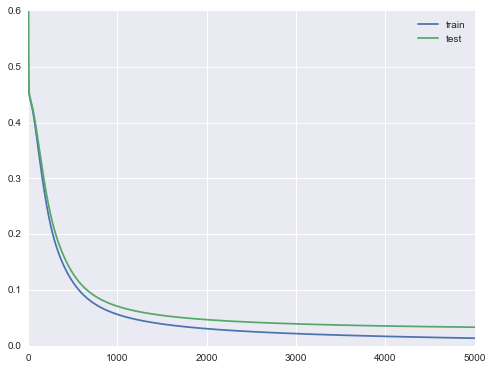

In [211]:
#initialize stuff
w_hid,w_out = initialize(target_size,feature_size,hidden_size)
learning_rate = 0.7/train_size
learning_rate_bias = 0.7/train_size
loss, loss_test = [],[]

#run configuration
max_epoch = 5000
min_loss_criterion = 0

#doing 1st forward pass to calculate loss
f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
loss.append(loss_func(Y_train,f_out,train_size))
f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
loss_test.append(loss_func(Y_test,f_out_test,test_size))

start_time = time.clock()

print 'start_loss = {}'.format(loss_test[0])

for i in range(0,max_epoch):
    
    #update the weights of output layer
    delta_out = (f_out - Y_train)*(f_out)*(1-f_out) #element-wise operation 
    wgrad_out = np.einsum('ki,kj->ij', delta_out, f_hid) #dot operation already sums it up     
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*np.sum(delta_out,axis=0)*1.0

    #update the weights of hidden layer
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation      
    wgrad_hid = np.einsum('ki,kj->ij',delta_hid,Xb[:,1:])
    w_hid[:,1:] = w_hid[:,1:] -learning_rate*wgrad_hid
    w_hid[:,0] = w_hid[:,0] -learning_rate_bias*np.sum(delta_hid,axis=0)*1.0
    
    #re-calculate loss
    f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
    loss.append(loss_func(Y_train,f_out,train_size))
    f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
    loss_test.append(loss_func(Y_test,f_out_test,test_size))

    #stopping criterion
    if (i>20) and ((loss_test[-11] - loss_test[-1]) < min_loss_criterion): #10th previous loss
        print 'stop at {}'.format(i)
        break

print 'end_loss = {}'.format(loss_test[-1])
print 'run time = {:.2f}s'.format(time.clock()-start_time)

df_run = pd.DataFrame(data=np.array([loss,loss_test]).T,columns=['train','test'])
df_run.plot()   
axes = plt.gca()
axes.set_ylim([0,0.6])


The program finishes after max 5,000 epoch (no early stop), the test set has a bit higher loss cost but it's actually stable, gradual curve downward.

In [213]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(cm_mat):
    accuracy = np.trace(cm_mat)*100.0/test_size
    print 'Test set Accuracy = {:.2f}%'.format(accuracy)
    df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
    plt.figure(figsize = (6,4),dpi=600)
    sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
    plt.title('Confusion Matrix')
    plt.xlabel('Truth')
    plt.ylabel('Predicted')

Test set Accuracy = 97.22%


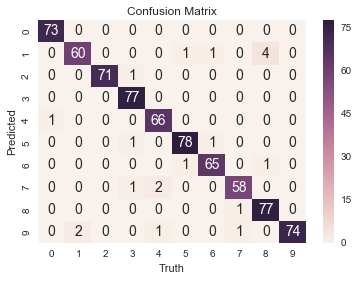

In [214]:
#get the prediction to compare with target
y_pred = np.argmax(f_out_test,axis=1)
cm_mat = confusion_matrix(digits.target[test_ix],y_pred)
show_confusion_matrix(cm_mat)

The confusion matrix with test dataset shows that the NN actually fits pretty well. Accuracy 95%+, similar to the training test.

---

### NN v2 - with L2 regularization

Now let's try with what we have learn: L2, early stop (already there), and dropout.
+ for L2, we can just change the loss func
+ for dropout, we can randomly set the f_hid result to 0.5.

In [202]:
def loss_func_L2(Y,y_pred,size,w_hid,w_out,scale_param):
    return loss_func(Y,y_pred,size) + 0.5*scale_param/size*(np.sum(w_hid**2)+np.sum(w_out**2)) 

start_loss = 1.45941414887
stop at 1782
end_loss = 0.117663081686
run time = 6.57s


(0, 0.4)

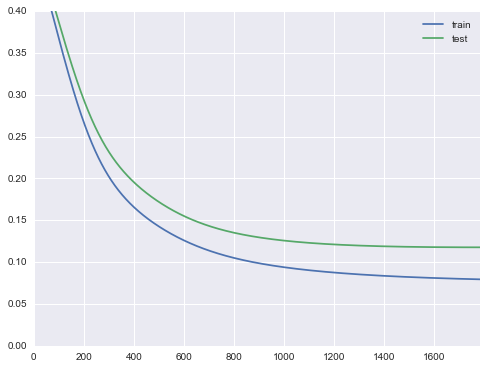

In [209]:
#initialize stuff
w_hid,w_out = initialize(target_size,feature_size,hidden_size)
learning_rate = 0.7/train_size
learning_rate_bias = 0.7/train_size
L2_scale_param = 0.2
loss, loss_test = [],[]

#run configuration
max_epoch = 5000
min_loss_criterion = 0

#doing 1st forward pass to calculate loss
f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

start_time = time.clock()

print 'start_loss = {}'.format(loss_test[0])

for i in range(0,max_epoch):
    
    #update the weights of output layer
    delta_out = (f_out - Y_train)*(f_out)*(1-f_out) #element-wise operation 
    wgrad_out = np.einsum('ki,kj->ij', delta_out, f_hid) #dot operation already sums it up     
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*np.sum(delta_out,axis=0)*1.0

    #update the weights of hidden layer
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation      
    wgrad_hid = np.einsum('ki,kj->ij',delta_hid,Xb[:,1:])
    w_hid[:,1:] = w_hid[:,1:] -learning_rate*wgrad_hid
    w_hid[:,0] = w_hid[:,0] -learning_rate_bias*np.sum(delta_hid,axis=0)*1.0
    
    #re-calculate loss
    f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
    loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
    f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
    loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

    #stopping criterion
    if (i>20) and ((loss_test[-11] - loss_test[-1]) < min_loss_criterion): #10th previous loss
        print 'stop at {}'.format(i)
        break

print 'end_loss = {}'.format(loss_test[-1])
print 'run time = {:.2f}s'.format(time.clock()-start_time)

df_run = pd.DataFrame(data=np.array([loss,loss_test]).T,columns=['train','test'])
df_run.plot()         
axes = plt.gca()
axes.set_ylim([0,0.4])

It stops before 2,000 epoch -- mainly due to the added L2 terms. 

Test set Accuracy = 96.52%


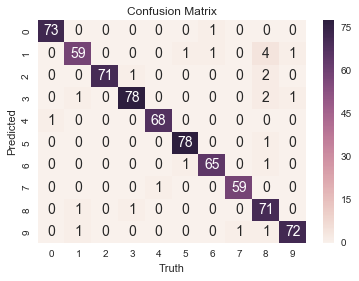

In [210]:
#get the prediction to compare with target
y_pred = np.argmax(f_out_test,axis=1)
cm_mat = confusion_matrix(digits.target[test_ix],y_pred)
show_confusion_matrix(cm_mat)

The accuracy does drop a bit, however the NN should be more robust (given new dataset, this test set seems to fit well even for v1, indicating there might be no need for L2).

---

## NN v3 - L2 and dropout

Now let's do it together with dropout.

we are implementing [this version](http://cs231n.github.io/neural-networks-2/) called "inverted dropout", scaling at training time.

In [215]:
def calc_forward_withdropout(w_hid,w_out,Xb,dropout_p):
    #drop hidden layer only
    f_hid = sigmoid(w_hid,Xb)
    dropout_mask_hid = (np.random.rand(*f_hid.shape) < dropout_p) / dropout_p
    f_hid *= dropout_mask_hid
    f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
    f_out = sigmoid(w_out,f_hid_b)
    return f_hid, f_hid_b, f_out

start_loss = 1.13877339938
stop at 1389
end_loss = 0.135667722879
run time = 6.05s


(0, 0.6)

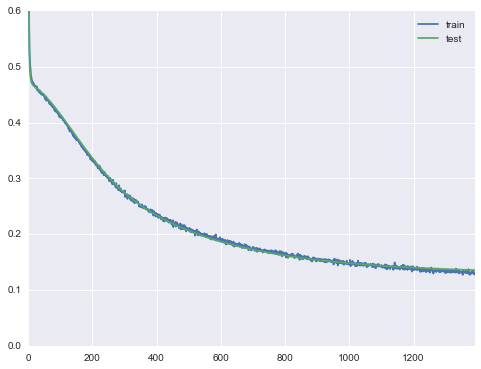

In [216]:
#initialize stuff
w_hid,w_out = initialize(target_size,feature_size,hidden_size)
learning_rate = 0.7/train_size
learning_rate_bias = 0.7/train_size
L2_scale_param = 0.2
loss, loss_test = [],[]

#add dropout parameter
dropout_p = 0.8 #chance of neuron not getting dropped.

#run configuration
max_epoch = 5000
min_loss_criterion = 0

#doing 1st forward pass to calculate loss
f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

start_time = time.clock()

print 'start_loss = {}'.format(loss_test[0])

for i in range(0,max_epoch):
    
    #update the weights of output layer
    delta_out = (f_out - Y_train)*(f_out)*(1-f_out) #element-wise operation 
    wgrad_out = np.einsum('ki,kj->ij', delta_out, f_hid) #dot operation already sums it up     
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*np.sum(delta_out,axis=0)*1.0

    #update the weights of hidden layer
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation      
    wgrad_hid = np.einsum('ki,kj->ij',delta_hid,Xb[:,1:])
    w_hid[:,1:] = w_hid[:,1:] -learning_rate*wgrad_hid
    w_hid[:,0] = w_hid[:,0] -learning_rate_bias*np.sum(delta_hid,axis=0)*1.0
    
    #re-calculate loss
    f_hid, f_hid_b, f_out = calc_forward_withdropout(w_hid,w_out,Xb,dropout_p)
    loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
    f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
    loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

    #stopping criterion
    if (i>20) and ((loss_test[-11] - loss_test[-1]) < min_loss_criterion): #10th previous loss
        print 'stop at {}'.format(i)
        break

print 'end_loss = {}'.format(loss_test[-1])
print 'run time = {:.2f}s'.format(time.clock()-start_time)

df_run = pd.DataFrame(data=np.array([loss,loss_test]).T,columns=['train','test'])
df_run.plot()         
axes = plt.gca()
axes.set_ylim([0,0.6])

There are a lot of "jiggling" on the losses of training dataset, due to the random dropout. However, the loss curve of test dataset is still a smooth downtrend.

Test set Accuracy = 94.44%


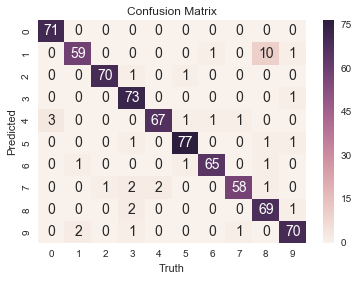

In [217]:
#get the prediction to compare with target
y_pred = np.argmax(f_out_test,axis=1)
cm_mat = confusion_matrix(digits.target[test_ix],y_pred)
show_confusion_matrix(cm_mat)

this is an interesting result. My interpretation is that our model is not "complex" enough due to the neuron dropout, instead now we have an underfitting rather than over fitting problem.

"one" and "eight" is really confusing for our NN.

---

### NN v4 - our tweaked model

Let's try tuning the parameters and optimize them for minimum loss cost on test dataset. 

start_loss = 1.28758871902
end_loss = 0.0308976207881


(0, 0.6)

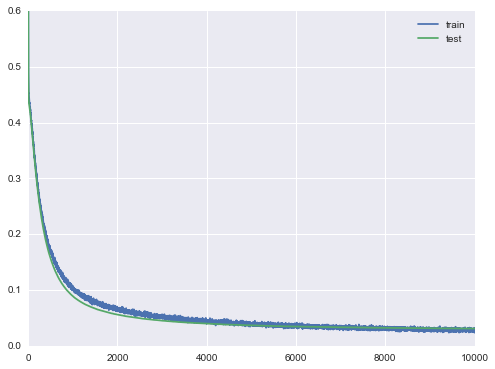

In [221]:
#change number of hidden neurons
hidden_size = 30

#initialize stuff
w_hid,w_out = initialize(target_size,feature_size,hidden_size)
learning_rate = 0.7/train_size
learning_rate_bias = 0.7/train_size
L2_scale_param = 0.00
loss, loss_test = [],[]

#add dropout parameter
dropout_p = 0.80 #chance of neuron not getting dropped.

#run configuration
max_epoch = 10000
min_loss_criterion = -10**-2

#doing 1st forward pass to calculate loss
f_hid, f_hid_b, f_out = calc_forward(w_hid,w_out,Xb)
loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

start_time = time.clock()

print 'start_loss = {}'.format(loss_test[0])

for i in range(0,max_epoch):
    
    #update the weights of output layer
    delta_out = (f_out - Y_train)*(f_out)*(1-f_out) #element-wise operation 
    wgrad_out = np.einsum('ki,kj->ij', delta_out, f_hid) #dot operation already sums it up     
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*np.sum(delta_out,axis=0)*1.0

    #update the weights of hidden layer
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation      
    wgrad_hid = np.einsum('ki,kj->ij',delta_hid,Xb[:,1:])
    w_hid[:,1:] = w_hid[:,1:] -learning_rate*wgrad_hid
    w_hid[:,0] = w_hid[:,0] -learning_rate_bias*np.sum(delta_hid,axis=0)*1.0
    
    #re-calculate loss
    f_hid, f_hid_b, f_out = calc_forward_withdropout(w_hid,w_out,Xb,dropout_p)
    loss.append(loss_func_L2(Y_train,f_out,train_size,w_hid,w_out,L2_scale_param))
    f_hid_test, f_hid_b_test, f_out_test = calc_forward(w_hid,w_out,Xb_test)
    loss_test.append(loss_func_L2(Y_test,f_out_test,test_size,w_hid,w_out,L2_scale_param))

    #stopping criterion
    if (i>20) and ((loss_test[-11] - loss_test[-1]) < min_loss_criterion): #10th previous loss
        print 'stop at {}'.format(i)
        break

print 'end_loss = {}'.format(loss_test[-1])

df_run = pd.DataFrame(data=np.array([loss,loss_test]).T,columns=['train','test'])
df_run.plot()         
axes = plt.gca()
axes.set_ylim([0,0.6])

Test set Accuracy = 97.22%


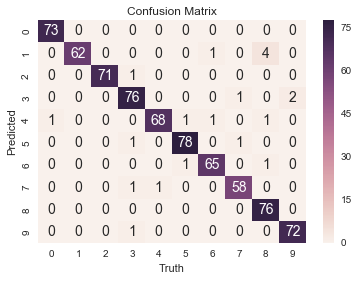

In [222]:
#get the prediction to compare with target
y_pred = np.argmax(f_out_test,axis=1)
cm_mat = confusion_matrix(digits.target[test_ix],y_pred)
show_confusion_matrix(cm_mat)

### Conclusion

It seems we are coming up to the limit of our simple 2-layer model. We double the epoch to 10K run and it still reaches at most around 97.2% accuracy or 2.8% error rate in our small test dataset.

Here are the historical best results from [official MNIST page](http://yann.lecun.com/exdb/mnist/), Neural Nets performance.


|                                Classifier                                	|          Pre-processing         	| Test error rate (%) 	|                               Reference                              	|
|:------------------------------------------------------------------------:	|:-------------------------------:	|:---------------:	|:--------------------------------------------------------------------:	|
| 2-layer NN, 300 hidden units, mean square error                          	|               none              	|       4.7       	|                           LeCun et al. 1998                          	|
| 2-layer NN, 300 HU, MSE, [distortions]                                   	|               none              	|       3.6       	|                           LeCun et al. 1998                          	|
| 2-layer NN, 300 HU                                                       	|            deskewing            	|       1.6       	|                           LeCun et al. 1998                          	|
| 3-layer NN, 300+100 hidden units                                         	|               none              	|       3.05      	|                           LeCun et al. 1998                          	|
| 3-layer NN, 500+150 HU [distortions]                                     	|               none              	|       2.45      	|                           LeCun et al. 1998                          	|
| 3-layer NN, 500+300 HU, softmax, cross entropy, weight decay             	|               none              	|       1.53      	|                       Hinton, unpublished, 2005                      	|
| 2-layer NN, 800 HU, Cross-Entropy Loss                                   	|               none              	|       1.6       	|                       Simard et al., ICDAR 2003                      	|
| 2-layer NN, 800 HU, cross-entropy [elastic distortions]                  	|               none              	|       0.7       	|                       Simard et al., ICDAR 2003                      	|
| 6-layer NN 784-2500-2000-1500-1000-500-10 (on GPU) [elastic distortions] 	|               none              	|       0.35      	| Ciresan et al. Neural Computation 10, 2010 and arXiv 1003.0358, 2010 	|
| committee of 25 NN 784-800-10 [elastic distortions]                      	| width normalization, deslanting 	|       0.39      	|                        Meier et al. ICDAR 2011                       	|
| deep convex net, unsup pre-training [no distortions]                     	|               none              	|       0.83      	|                     Deng et al. Interspeech 2010                     	|
| Convolutional net LeNet-1                                                	|   subsampling to 16x16 pixels   	|       1.7       	|                           LeCun et al. 1998                          	|
| Convolutional net LeNet-4                                                	|               none              	|       1.1       	|                           LeCun et al. 1998                          	|
| Convolutional net LeNet-5, [no distortions]                              	|               none              	|       0.95      	|                           LeCun et al. 1998                          	|
| Convolutional net LeNet-5, [distortions]                                 	|               none              	|       0.8       	|                           LeCun et al. 1998                          	|
| Convolutional net Boosted LeNet-4, [distortions]                         	|               none              	|       0.7       	|                           LeCun et al. 1998                          	|
| Trainable feature extractor + SVMs [no distortions]                      	|               none              	|       0.83      	|             Lauer et al., Pattern Recognition 40-6, 2007             	|
| Trainable feature extractor + SVMs [elastic distortions]                 	|               none              	|       0.56      	|             Lauer et al., Pattern Recognition 40-6, 2007             	|
| Trainable feature extractor + SVMs [affine distortions]                  	|               none              	|       0.54      	|             Lauer et al., Pattern Recognition 40-6, 2007             	|
| unsupervised sparse features + SVM, [no distortions]                     	|               none              	|       0.59      	|                     Labusch et al., IEEE TNN 2008                    	|
| Convolutional net, cross-entropy [elastic distortions]                   	|               none              	|       0.4       	|                       Simard et al., ICDAR 2003                      	|
| large conv. net, random features [no distortions]                        	|               none              	|       0.89      	|                       Ranzato et al., CVPR 2007                      	|
| large conv. net, unsup features [no distortions]                         	|               none              	|       0.62      	|                       Ranzato et al., CVPR 2007                      	|
| large conv. net, unsup pretraining [elastic distortions]                 	|               none              	|       0.39      	|                       Ranzato et al., NIPS 2006                      	|
| large conv. net, unsup pretraining [no distortions]                      	|               none              	|       0.53      	|                       Jarrett et al., ICCV 2009                      	|
| large/deep conv. net, 1-20-40-60-80-100-120-120-10 [elastic distortions] 	|               none              	|       0.35      	|                       Ciresan et al. IJCAI 2011                      	|
| committee of 7 conv. net, 1-20-P-40-P-150-10 [elastic distortions]       	|       width normalization       	|   0.27 +-0.02   	|                       Ciresan et al. ICDAR 2011                      	|
| committee of 35 conv. net, 1-20-P-40-P-150-10 [elastic distortions]      	|       width normalization       	|       0.23      	|                       Ciresan et al. CVPR 2012                       	|

---